In [30]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (29.4 MB/s)
debconf: unable to initia

In [31]:
pip install pytesseract

In [48]:
import numpy as np
import cv2
from PIL import Image
import pytesseract as tess
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

In [49]:
def ratioCheck(area, width, height):
    ratio = float(width) / float(height)
    if ratio < 1:
        ratio = 1 / ratio
    if (area < 1063.62 or area > 73862.5) or (ratio < 3 or ratio > 6):
        return False
    return True

In [50]:
def isMaxWhite(plate):
    avg = np.mean(plate)
    if(avg>=115):
        return True
    else:
         return False

In [51]:
def ratio_and_rotation(rect):
    (x, y), (width, height), rect_angle = rect
    if(width>height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle
    if angle>15:
         return False
    if height == 0 or width == 0:
        return False
    area = height*width
    if not ratioCheck(area,width,height):
        return False
    else:
        return True

In [52]:
def clean2_plate(plate):
    gray_img = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_img, 110, 255, cv2.THRESH_BINARY)
    if cv2.waitKey(0) & 0xff == ord('q'):
        pass
    num_contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if num_contours:
        contour_area = [cv2.contourArea(c) for c in num_contours]
        max_cntr_index = np.argmax(contour_area)
        max_cnt = num_contours[max_cntr_index]
        max_cntArea = contour_area[max_cntr_index]
        x,y,w,h = cv2.boundingRect(max_cnt)
        if not ratioCheck(max_cntArea,w,h):
            return plate,None
        final_img = thresh[y:y+h, x:x+w]
        return final_img,[x,y,w,h]
    else:
        return plate, None

Number  input image...


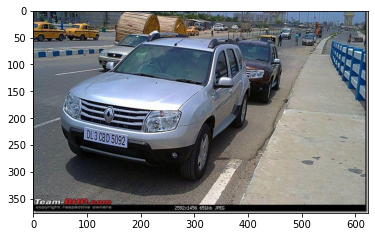

In [56]:
img = cv2.imread("10.jpg")
im_rgb = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
print("Number  input image...",)
plt.imshow(im_rgb)
plt.show()

Number  identified number plate...


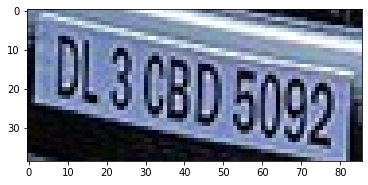

Number  identified number plate...
Number  Detected Plate Text :  


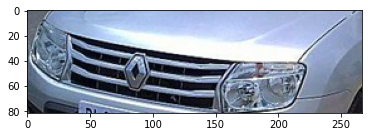

Number  identified number plate...


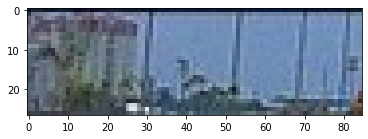

In [57]:

if cv2.waitKey(0) & 0xff == ord('q'):
    pass
img2 = cv2.GaussianBlur(img, (3,3), 0)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2 = cv2.Sobel(img2,cv2.CV_8U,1,0,ksize=3)    
_,img2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
morph_img_threshold = img2.copy()
cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
num_contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img2, num_contours, -1, (0,255,0), 1)
for i,cnt in enumerate(num_contours):
    min_rect = cv2.minAreaRect(cnt)
    if ratio_and_rotation(min_rect):
        x,y,w,h = cv2.boundingRect(cnt)
        plate_img = img[y:y+h,x:x+w]
        plate_img_rgb = cv2.cvtColor(plate_img.copy(), cv2.COLOR_BGR2RGB)
        print("Number  identified number plate...")
        plt.imshow(plate_img_rgb)
        if cv2.waitKey(0) & 0xff == ord('q'):
            pass
        if(isMaxWhite(plate_img)):
            clean_plate, rect = clean2_plate(plate_img)
            if rect:
                fg=0
                x1,y1,w1,h1 = rect
                x,y,w,h = x+x1,y+y1,w1,h1
                plate_im = Image.fromarray(clean_plate)
                text = tess.image_to_string(plate_im, lang='eng')
                print("Number  Detected Plate Text : ",text)
        plt.show()

In [ ]:
#!wget --no-check-certificate \
# for downloading from web